# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from statsmodels.multivariate.pca import PCA as PCA_sm
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.manifold import Isomap
import warnings
import scipy.sparse as sp
import pickle

# Ignore specific warning categories
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=sp.SparseEfficiencyWarning)

# Dataset Analysis

In [2]:
# Load the dataset
df = pd.read_csv('csv/train_data.csv')

# Unneeded
df = df.drop(columns=['Unnamed: 0'])
df = df.drop_duplicates()

# Labeled subset (for training the supervised model)
df_labeled = df[df['SurvivalTime'].notna()]

Make a balanced dataset where the number of censored samples is the same as the number of non-censored ones

In [3]:
# Separate rows by label
label_0 = df_labeled[df_labeled['Censored']==0]
label_1 = df_labeled[df_labeled['Censored']==1]
        
# Count the number of each label
count_label_0 = len(label_0)
count_label_1 = len(label_1)

# Calculate the number of duplications needed
label_1_dupes_needed = int(count_label_0 - count_label_1)

# Duplicate rows of label 1 and 2 to match the count of label 0
label_1_duplicated = label_1.sample(n=label_1_dupes_needed, replace=True, random_state=42)

# Concatenate the duplicated rows with their original counterparts
df_balanced = pd.concat([label_0, label_1, label_1_duplicated])

# Shuffle the DataFrame to mix the rows
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


Check for dataset metrics

In [ ]:
# Pandas profiler
profile = ProfileReport(df)
profile.to_notebook_iframe()

# Data Preprocessing

In [4]:
class PCA_sm_wrapper_scale_only(BaseEstimator, TransformerMixin):

    def __init__(self, ncomp=None, standardize=True, demean=True, normalize=True, gls=False, weights=None, method='svd', missing=None, tol=5e-08, max_iter=1000, tol_em=5e-08, max_em_iter=100, svd_full_matrices=False):
        self.ncomp = ncomp
        self.standardize = standardize
        self.demean = demean
        self.normalize = normalize
        self.gls = gls
        self.weights = weights
        self.method = method
        self.missing = missing
        self.tol = tol
        self.max_iter = max_iter
        self.tol_em = tol_em
        self.max_em_iter = max_em_iter
        self.svd_full_matrices = svd_full_matrices


    def fit(self, X, y=None):
        self.pca = PCA_sm(X, ncomp=self.ncomp, standardize=self.standardize, demean=self.demean, normalize=self.normalize, gls=self.gls, weights=self.weights, method=self.method, missing=self.missing, tol=self.tol, max_iter=self.max_iter, tol_em=self.tol_em, max_em_iter=self.max_em_iter, svd_full_matrices=self.svd_full_matrices)
        return self.pca.transformed_data

    def transform(self, X):
        self.pca = PCA_sm(X, ncomp=self.ncomp, standardize=self.standardize, demean=self.demean, normalize=self.normalize, gls=self.gls, weights=self.weights, method=self.method, missing=self.missing, tol=self.tol, max_iter=self.max_iter, tol_em=self.tol_em, max_em_iter=self.max_em_iter, svd_full_matrices=self.svd_full_matrices)
        return self.pca.transformed_data


    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)
    
    def __str__(self) -> str:
        return super().__str__() + 'PCA_sm_wrapper_scale_only'

In [5]:
class PCA_sm_wrapper(BaseEstimator, TransformerMixin):

    def __init__(self, ncomp=None, standardize=True, demean=True, normalize=True, gls=False, weights=None, method='svd', missing=None, tol=5e-08, max_iter=1000, tol_em=5e-08, max_em_iter=100, svd_full_matrices=False):
        self.ncomp = ncomp
        self.standardize = standardize
        self.demean = demean
        self.normalize = normalize
        self.gls = gls
        self.weights = weights
        self.method = method
        self.missing = missing
        self.tol = tol
        self.max_iter = max_iter
        self.tol_em = tol_em
        self.max_em_iter = max_em_iter
        self.svd_full_matrices = svd_full_matrices


    def fit(self, X, y=None):
        self.pca = PCA_sm(X, ncomp=self.ncomp, standardize=self.standardize, demean=self.demean, normalize=self.normalize, gls=self.gls, weights=self.weights, method=self.method, missing=self.missing, tol=self.tol, max_iter=self.max_iter, tol_em=self.tol_em, max_em_iter=self.max_em_iter, svd_full_matrices=self.svd_full_matrices)
        return self.pca.factors

    def transform(self, X):
        self.pca = PCA_sm(X, ncomp=self.ncomp, standardize=self.standardize, demean=self.demean, normalize=self.normalize, gls=self.gls, weights=self.weights, method=self.method, missing=self.missing, tol=self.tol, max_iter=self.max_iter, tol_em=self.tol_em, max_em_iter=self.max_em_iter, svd_full_matrices=self.svd_full_matrices)
        return self.pca.factors


    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)
    
    def __str__(self) -> str:
        return super().__str__() + 'PCA_sm_wrapper'

In [6]:
class PreFitTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer):
        self.transformer = transformer

    def fit(self, X, y=None):
        # Transformer is already fitted
        return self.transformer

    def transform(self, X):
        return self.transformer.transform(X)
    
    def __str__(self) -> str:
        return super().__str__() + f'({self.transformer})'

In [6]:
X = df.drop(columns=['SurvivalTime', 'Censored'])   # Labeled and unlabeled data

dimensions = 2

supervised_preprocessors = {'Handled': [], 'Unhandled': []}
semi_supervised_preprocessors = []

numerical_features = ['Age']
categorical_features = ['Gender', 'Stage', 'GeneticRisk', 'TreatmentType', 'ComorbidityIndex', 'TreatmentResponse']

# Preprocessors for missing values
numeric_inputers = [SimpleImputer(strategy='mean'), IterativeImputer(), KNNImputer()]
categorical_inputers = [SimpleImputer(strategy='most_frequent'), IterativeImputer(), KNNImputer()]


def create_column_transformer(numeric_imputer=None, categorical_inputer=None):

    if numeric_imputer is not None:
        numeric_transformer = Pipeline(steps=[('imputer', numeric_imputer),
                                          ('scaler', StandardScaler())])
       
    else:
        numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
        
    if categorical_inputer is not None:
        categorical_transformer = Pipeline(steps=[('imputer', categorical_inputer),
                                                ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
    
    else:
        categorical_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])


    column_transformer = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features),
                                                       ('cat', categorical_transformer, categorical_features)])
    
    return column_transformer


def create_dimensionality_reduction(column_transformer):
    # Dimensionality reduction
    pca = PCA(n_components=dimensions)
    isomap = Isomap(n_components=dimensions)

    X_scaled = column_transformer.fit_transform(X)

    pca.fit(X_scaled)
    isomap.fit(X_scaled)

    dimensionality_reduction = [('prefitpca', PreFitTransformer(pca)), 
                                ('prefitisomap', PreFitTransformer(isomap)), 
                                ('pca', PCA(n_components=dimensions)), 
                                ('isomap', Isomap(n_components=dimensions))]
    
    return dimensionality_reduction
    


# Create multiple combinations of preprocessors
for numeric_imputer, categorical_inputer in zip(numeric_inputers, categorical_inputers):

    column_transformer = create_column_transformer(numeric_imputer, categorical_inputer)

    supervised_preprocessors['Handled'].append(Pipeline(steps=[('columntransformer', column_transformer)]))
    
    dimensionality_reduction = create_dimensionality_reduction(column_transformer)
    
    for dim_red in dimensionality_reduction:
        if 'prefit' in dim_red[0]:
            semi_supervised_preprocessors.append(Pipeline(steps=[('columntransformer', column_transformer), dim_red]))

        else:
            supervised_preprocessors['Handled'].append(Pipeline(steps=[('columntransformer', column_transformer), dim_red]))

# Create preprocessors that do not handle missing values
# Since these preprocessors do not handle missing values, they cannot use dimensionality reduction
column_transformer = create_column_transformer()
supervised_preprocessors['Unhandled'].append(Pipeline(steps=[('columntransformer', column_transformer)]))

# This preprocessor uses the PCA's built-in imputation and scaling (CANNOT MAKE USE OF UNLABELED DATA FOR OUR PURPOSES)
# Therefore it is not included in the semi-supervised preprocessors
preprocessor_smpca_scale_only = Pipeline(steps=[('smpca', PCA_sm_wrapper_scale_only(missing='fill-em', ncomp=2))])
preprocessor_smpca = Pipeline(steps=[('smpca', PCA_sm_wrapper(missing='fill-em', ncomp=2))])

supervised_preprocessors['Handled'].append(preprocessor_smpca_scale_only)
supervised_preprocessors['Handled'].append(preprocessor_smpca)

# Pipelines

In [7]:
# This method uses only the labeled subset to train the model
semi_supervised_pipelines = {}   # Dictionary of pipelines (model_name: list of pipelines)
supervised_pipelines = {}   # Dictionary of pipelines (model_name: list of pipelines)

models = [('LinearRegression', LinearRegression()), ('Ridge', Ridge()), ('KNeighborsRegressor', KNeighborsRegressor()), ('DecisionTreeRegressor', DecisionTreeRegressor()), ('RandomForestRegressor', RandomForestRegressor()), ('SVR', SVR())]

# These models hanlde missing values by themselves
gradient_boosting_models = [('GradientBoostingRegressor', HistGradientBoostingRegressor())]

# Initialize pipeline list for each type model
for model_name, model in models:
    semi_supervised_pipelines[model_name] = []
    supervised_pipelines[model_name] = []

for model_name, model in gradient_boosting_models:
    supervised_pipelines[model_name] = []


# Create multiple combinations of preprocessors and models
# Semi-supervised
for preprocessor in semi_supervised_preprocessors:
    for model_name, model in models:
        semi_supervised_pipelines[model_name].append(Pipeline(steps=[('preprocessor', preprocessor),
                                                                    ('model', model)]))

# Supervised
for preprocessor in supervised_preprocessors['Handled']:
    for model_name, model in models:
        supervised_pipelines[model_name].append(Pipeline(steps=[('preprocessor', preprocessor),
                                                                ('model', model)]))
        
for preprocessor in supervised_preprocessors['Unhandled']:
    for model_name, model in gradient_boosting_models:
        supervised_pipelines[model_name].append(Pipeline(steps=[('preprocessor', preprocessor),
                                                                ('model', model)]))


# Training and Evaluation

In [27]:
def cMSE(y_hat, y, c):
  err = y-y_hat
  err = (1-c)*err**2 + c*np.maximum(0,err)**2
  return np.sum(err)/err.shape[0]

def MSE(y_hat, y, c):
  err = y-y_hat
  err = err**2
  return np.sum(err)/err.shape[0]

def RMSE (y_hat, y, c):
  err = y-y_hat
  err = err**2
  return np.sqrt(np.sum(err)/err.shape[0])

def MAE(y_hat, y, c):
  err = y-y_hat
  err = np.abs(err)
  return np.sum(err)/err.shape[0]

def r_squared(y_hat, y, c):
  y_mean = np.mean(y)
  err = y-y_hat
  err = err**2
  err_mean = y-y_mean
  err_mean = err_mean**2
  return 1-np.sum(err)/np.sum(err_mean)


def calc_fold(pipeline, X, y, train_ix, test_ix, error_func):
    """return regression error for train and test"""
    censored = X['Censored']
    X = X.drop(columns=['Censored'])
    print(X.shape)
    
    pipeline.fit(X.iloc[train_ix, :], y.iloc[train_ix])

    training_err = error_func(pipeline.predict(X.iloc[train_ix, :]), y.iloc[train_ix], censored.iloc[train_ix])
    test_err = error_func(pipeline.predict(X.iloc[test_ix, :]), y.iloc[test_ix], censored.iloc[test_ix])
    
    return training_err, test_err

def calc_test_error(pipeline, X_train, y_train, X_test, y_test, error_func):
    """return regression error for train and test"""
    censored = X_test['Censored']
    

    X_train = X_train.drop(columns=['Censored'])
    X_test = X_test.drop(columns=['Censored'])

    print(X_train.shape)

    pipeline.fit(X_train, y_train)

    test_err = error_func(pipeline.predict(X_test), y_test, censored)
    
    return test_err

In [28]:
def cross_validation(df, pipelines, error_func):
    """
    Perform cross validation on the given pipelines using the given data and error function
    
    return the errors and best performing model
    """
    print(f"Error function: {error_func.__name__}")

    X = df.drop(columns=['SurvivalTime'])
    censored = df['Censored']

    y = df['SurvivalTime']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=censored)

    folds = 5
    skf = StratifiedKFold(n_splits = folds)
    lowest_val_err = 100000
    errs={}
    best_model_name = ''
    best_model = None

    for model_name in pipelines:  # for each set of pipelines (that use the same model)

        errs[model_name] = []

        for pipeline_number, pipeline in enumerate(pipelines[model_name]):    # for each pipeline in the set
        
            tr_err = va_err = 0
                
            for tr_ix, va_ix in skf.split(X_train, X_train["Censored"]):  # for each fold
                r, v = calc_fold(pipeline, X_train, y_train, tr_ix, va_ix, error_func)  # (r = training error, v = validation error) for current pipeline
                tr_err += r
                va_err += v

            tr_err = tr_err/folds
            va_err = va_err/folds

            # Print errors with 4 decimal places
            print(f"{model_name} {pipeline_number}; Training Error: {tr_err:.4f}; Validation Error: {va_err:.4f}")
            errs[model_name].append((tr_err, va_err))
                
            if(va_err < lowest_val_err):
                lowest_val_err = va_err
                best_model_name = model_name + " " + str(pipeline_number)
                best_model = pipeline

        print("-----------------------------------------------")

    test_error = calc_test_error(best_model, X_train, y_train, X_test, y_test, error_func) 
    print(f"Best model: {best_model_name}, with test error: {test_error:.4f}")
    return errs, best_model

In [29]:
supervised_errors, supervised_best_model = cross_validation(df_labeled, supervised_pipelines, cMSE)
supervised_best_model

Error function: cMSE
(247, 7)
(247, 7)
(247, 7)
(247, 7)
(247, 7)
LinearRegression 0; Training Error: 1.3714; Validation Error: 1.4609
(247, 7)
(247, 7)
(247, 7)
(247, 7)
(247, 7)
LinearRegression 1; Training Error: 1.4573; Validation Error: 1.4797
(247, 7)
(247, 7)
(247, 7)
(247, 7)
(247, 7)
LinearRegression 2; Training Error: 1.4867; Validation Error: 1.5066
(247, 7)
(247, 7)
(247, 7)
(247, 7)
(247, 7)
LinearRegression 3; Training Error: 1.3634; Validation Error: 1.4775
(247, 7)
(247, 7)
(247, 7)
(247, 7)
(247, 7)
LinearRegression 4; Training Error: 1.6476; Validation Error: 1.7018
(247, 7)
(247, 7)
(247, 7)
(247, 7)
(247, 7)
LinearRegression 5; Training Error: 1.6520; Validation Error: 1.7096
(247, 7)
(247, 7)
(247, 7)
(247, 7)
(247, 7)
LinearRegression 6; Training Error: 1.3665; Validation Error: 1.4591
(247, 7)
(247, 7)
(247, 7)
(247, 7)
(247, 7)
LinearRegression 7; Training Error: 1.6575; Validation Error: 1.7021
(247, 7)
(247, 7)
(247, 7)
(247, 7)
(247, 7)
LinearRegression 8; Tr

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('smpca',
                                  PCA_sm_wrapper_scale_only(missing='fill-em',
                                                            ncomp=2))])),
                ('model', Ridge())])

In [16]:
semi_supervised_errors, semi_supervised_best_model = cross_validation(df_labeled, semi_supervised_pipelines, cMSE)
semi_supervised_best_model

Error function: cMSE
LinearRegression 0; Training Error: 1.4566; Validation Error: 1.4765
LinearRegression 1; Training Error: 1.4692; Validation Error: 1.4884
LinearRegression 2; Training Error: 1.6478; Validation Error: 1.7017
LinearRegression 3; Training Error: 1.6494; Validation Error: 1.7037
LinearRegression 4; Training Error: 1.6581; Validation Error: 1.6974
LinearRegression 5; Training Error: 1.6534; Validation Error: 1.6838
-----------------------------------------------
Ridge 0; Training Error: 1.4566; Validation Error: 1.4765
Ridge 1; Training Error: 1.4692; Validation Error: 1.4884
Ridge 2; Training Error: 1.6478; Validation Error: 1.7017
Ridge 3; Training Error: 1.6494; Validation Error: 1.7037
Ridge 4; Training Error: 1.6581; Validation Error: 1.6974
Ridge 5; Training Error: 1.6534; Validation Error: 1.6838
-----------------------------------------------
KNeighborsRegressor 0; Training Error: 1.1951; Validation Error: 1.6940
KNeighborsRegressor 1; Training Error: 1.2236; Va

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['Gender',
                                                                    'Stage',
                                                                    'GeneticRisk',
                                                                    'TreatmentType',
                                                                    'ComorbidityIndex',
                                                                    'TreatmentResponse'])])),
                                 ('prefitpca',
                                  PreFitTransformer(transformer=PCA(n_components=2)))])),
                ('model', Ridge())])

In [15]:
def plot_errors(errs):
    plt.figure(figsize=(8, 8), frameon=True)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e7bcbc']  # add more colors if needed

    for (model_name, err_values), color in zip(errs.items(), colors):
        tr_errors, va_errors = zip(*err_values)
        plt.plot(range(0, len(tr_errors)), tr_errors, marker='x', color=color, label=f'{model_name} Training')
        plt.plot(range(0, len(va_errors)), va_errors, marker='o', linestyle='-.', color=color, label=f'{model_name} Validation')


    number_of_models = errs['LinearRegression'].__len__()
    plt.xlabel('Model Number')
    plt.ylabel('Error')
    plt.xticks(np.arange(0, number_of_models, step=1))
    plt.title('Training and Validation Errors for Each Model')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.savefig('L05-lagreg-error.png', dpi=300, bbox_inches="tight")

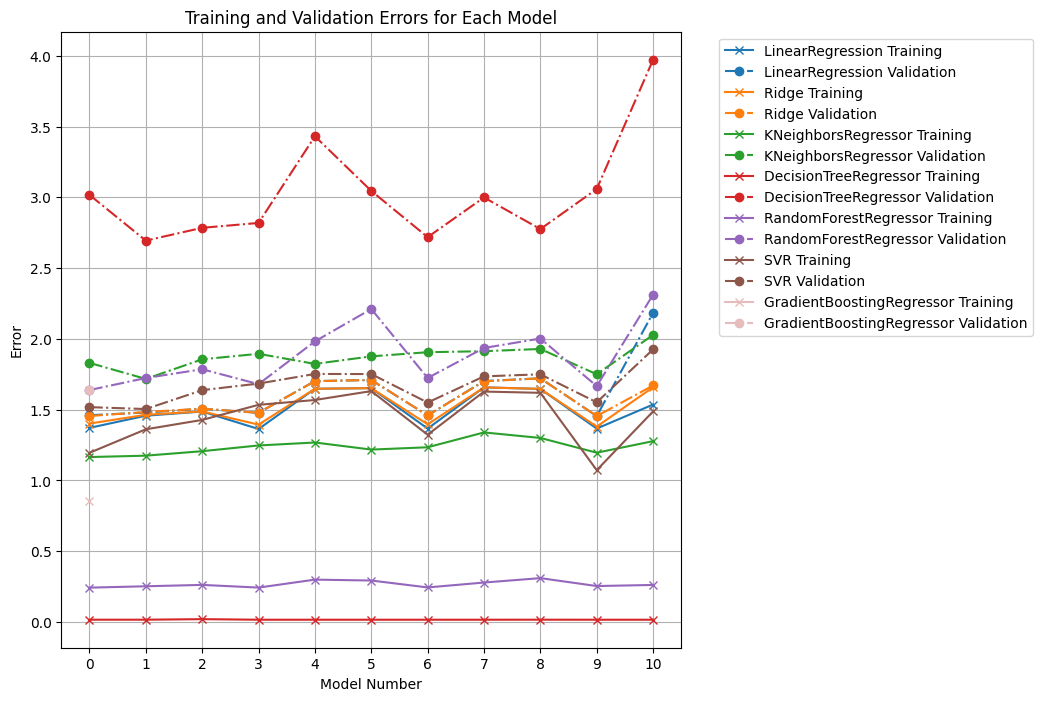

In [16]:
%matplotlib inline
plot_errors(supervised_errors)

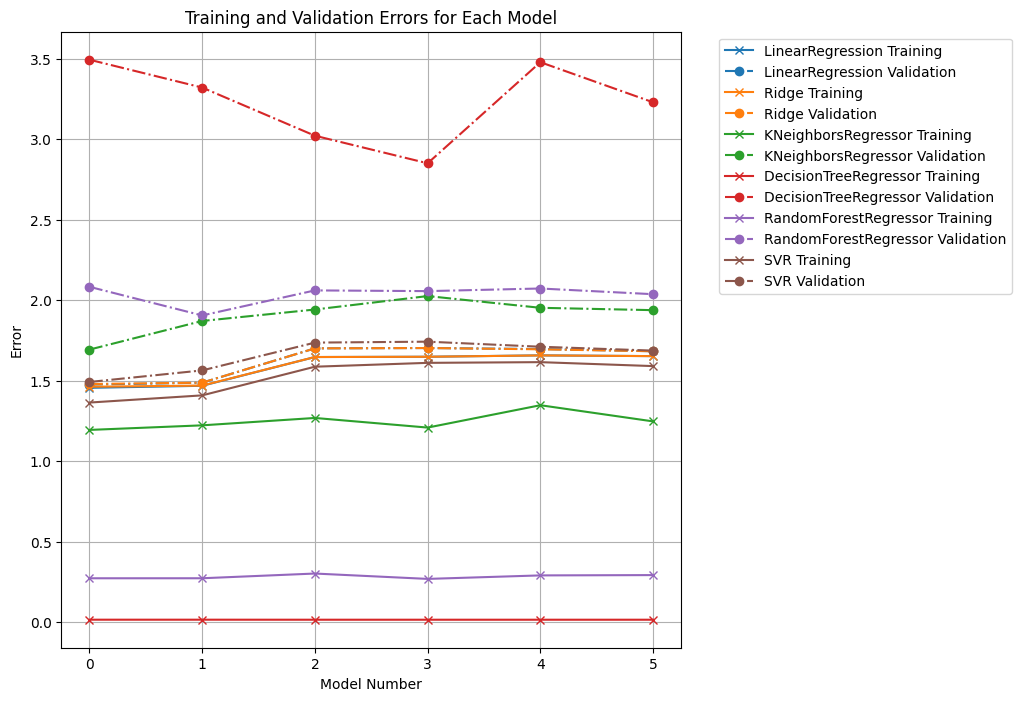

In [17]:
%matplotlib inline
plot_errors(semi_supervised_errors)

# Hyper Parameter Tuning

In [21]:
best_model = supervised_best_model
best_model

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('smpca',
                                  PCA_sm_wrapper_scale_only(missing='fill-em',
                                                            ncomp=2))])),
                ('model', LinearRegression())])

In [18]:
best_model = semi_supervised_best_model
best_model

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['Gender',
                                                                    'Stage',
                                                                    'GeneticRisk',
                                                                    'TreatmentType',
                                                                    'ComorbidityIndex',
                                                                    'TreatmentResponse'])])),
                                 ('prefitpca',
                                  PreFitTransformer(transformer=PCA(n_components=2)))])),
                ('model', Ridge())])

In [ ]:
from sklearn.metrics import make_scorer
# Define hyperparameters grid to search through (best model is Ridge)
X = df_labeled.drop(columns=['SurvivalTime', 'Censored'])
y = df_labeled['SurvivalTime']

# Define hyperparameters grid to search through
param_grid = {
    'model__alpha': [0.1, 1.0, 10.0],
    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Wrap the cMSE function into a scorer usable by GridSearchCV
def cMSE_scorer(y, y_hat, c):
    return cMSE(y_hat, y, c)

cms_error = make_scorer(cMSE_scorer, c=df_labeled['Censored'], greater_is_better=False)

# GridSearchCV to find the best hyperparameters using cross-validation
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring=cms_error, verbose=1, n_jobs=-1)
grid_search.fit(X, y)

# Retrieve the best parameters and best score found by GridSearchCV
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_estimator = grid_search.best_estimator_

best_model = best_estimator

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")
print(f"Best estimator: {best_estimator}")

# Feature analysis

In [34]:
# Make a coefficient table for purely supervised models (linear and ridge regression)
coefficients = [supervised_pipelines['LinearRegression'][9]['model'].coef_, supervised_pipelines['Ridge'][9]['model'].coef_]
columns = df.columns.drop(['SurvivalTime', 'Censored'])

# Index is the model name
index = [supervised_pipelines['LinearRegression'][9]['model'].__str__(), supervised_pipelines['Ridge'][9]['model'].__str__()]
coefficients = pd.DataFrame(coefficients, columns=columns, index=index)
coefficients

[array([-0.09690866,  0.06956613, -0.38019929, -0.01550654,  0.27166603,
       -0.01965617, -0.1052708 ]), array([-0.096571  ,  0.06925961, -0.37900082, -0.01566015,  0.27079214,
       -0.01994687, -0.10488289])]


,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse
LinearRegression(),-0.096909,0.069566,-0.380199,-0.015507,0.271666,-0.019656,-0.105271
Ridge(),-0.096571,0.069260,-0.379001,-0.015660,0.270792,-0.019947,-0.104883


# Save Model

In [33]:
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Load Model

In [7]:
best_model = pickle.load(open('models/model_2.pkl', 'rb'))

# Submission Prediction

In [19]:
# Train submission model on the whole dataset
X = df_labeled.drop(columns=['SurvivalTime', 'Censored'])
y = df_labeled['SurvivalTime']

best_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['Gender',
                                                                    'Stage',
                                                                    'GeneticRisk',
                                                                    'TreatmentType',
                                                                    'ComorbidityIndex',
                                                                    'TreatmentResponse'])])),
                                 ('prefitpca',
                                  PreFitTransformer(transformer=PCA(n_components=2)))])),
                ('model', Ridge())])

In [25]:
final_test_dataset = pd.read_csv('csv/test_data.csv').drop(columns=['id'])
submission_pred = best_model.predict(final_test_dataset)

In [26]:
submission_pred_df = pd.DataFrame(submission_pred, columns=['TARGET'])
submission_pred_df.insert(0, 'id', range(0, len(submission_pred_df)))
submission_pred_df.to_csv('submission_pred.csv', index=False)